# Project: Category prediction of IKEA furniture

## Data Visualization

In [6]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="white")


%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots

In [7]:
#read the data and delete the index of entry
IKEA_df = pd.read_csv('Data/IKEA_SA_Furniture_Web_Scrapings_sss.csv')
IKEA_df = IKEA_df.drop(IKEA_df.columns[0],axis =1)

In [8]:
IKEA_df.head(2)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0


In [9]:
m = IKEA_df.shape[0]
n = IKEA_df.shape[1]
print('We have '+str(m)+' sample sand '+str(n-1)+' features together with the target category')

We have 3694 sample sand 12 features together with the target category


data type of 12 features together with target category are shown as follows:

In [10]:
# data type  
IKEA_df.dtypes

item_id                int64
name                  object
category              object
price                float64
old_price             object
sellable_online         bool
link                  object
other_colors          object
short_description     object
designer              object
depth                float64
height               float64
width                float64
dtype: object

We can see that some data is missing in feature depth, height and width 

In [11]:
IKEA_df.count() 

# wouldn't it be prettier if we only print the features for which that is the case instead of all of them?
# simply a suggestion...

max_count = max(IKEA_df.count())

missing_data = []
for i in range(len(IKEA_df.count())):
        if IKEA_df.count()[i] < max_count:
            missing_data.append(i)
            
IKEA_df.count()[missing_data]

depth     2231
height    2706
width     3105
dtype: int64

## Target and features
Now we start to examine the properties of data for each features, which help us better understand the dataset and gives us an ideas of how to clean the dataset.

### item_id

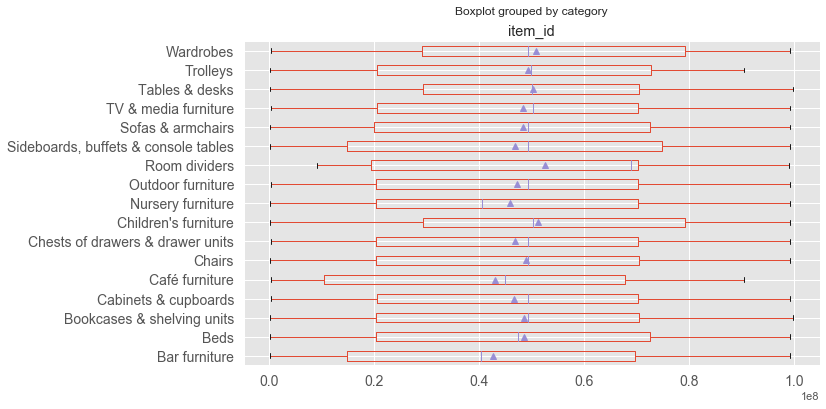

In [12]:
ax0 = IKEA_df.boxplot(column='item_id',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax0.set_xlabel('')
ax0.figure.savefig('Figures/item_id_boxplot.pdf',bbox_inches = 'tight')

In [13]:
nun_id =  IKEA_df['item_id'].nunique()
print('There are ' + str(nun_id)+' unique item_ids.')
if nun_id <  m:
    print('item_id is not unique for samples, some samples share same id or might be same one.')

There are 2962 unique item_ids.
item_id is not unique for samples, some samples share same id or might be same one.


The item_id is a number consisting of 5 to 8 digits. In the boxplot above we can see, that approximately 50% of the items of most categories are taking a value between 2e^7 to 7e^7. This means that item_id might does not give strong evidence of category.   

### name

In [14]:
nun =  IKEA_df['name'].nunique()
#print(IKEA_df['category'].unique())
print('There are ' + str(nun) + ' unique name in total' )

There are 607 unique name in total


### category

In [15]:
nun =  IKEA_df['category'].nunique()
#print(IKEA_df['category'].unique())
print('There are ' + str(nun) + ' categories in total' )

There are 17 categories in total


In [16]:
type_df = IKEA_df.groupby('category').size().reset_index(name='size').sort_values(['size'], ascending=False) 
type_df

,category,size
14,Tables & desks,612
2,Bookcases & shelving units,548
5,Chairs,481
12,Sofas & armchairs,428
3,Cabinets & cupboards,292
16,Wardrobes,236
9,Outdoor furniture,216
1,Beds,208
13,TV & media furniture,190
6,Chests of drawers & drawer units,125


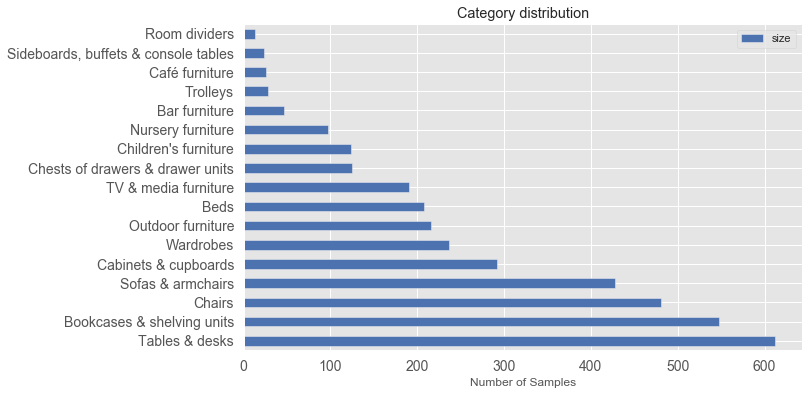

In [17]:
ax1 = type_df.set_index('category').plot.barh(rot=0, title='Category distribution',color = 'b',figsize=(10,6), fontsize=14)
ax1.set_xlabel("Number of Samples")
ax1.set_ylabel('')
ax1.figure.savefig('Figures/category_distribution.pdf',bbox_inches = 'tight')


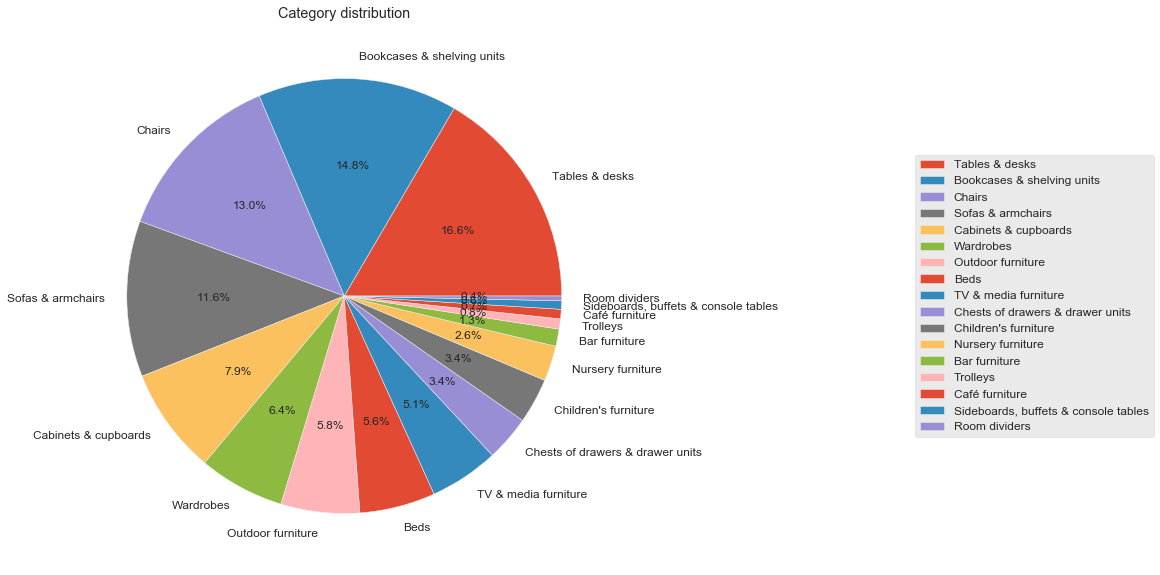

In [18]:
ax = type_df.set_index('category').plot.pie(title='Category distribution', y='size',figsize=(10,10), autopct='%1.1f%%',fontsize=12)
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(2,0.5), loc="right", fontsize=12)
ax.figure.savefig('Figures/category_plotpie.pdf',bbox_inches = 'tight')

From the graph we can observe that more than 16% of the data samples are from the category Tables & desks, followed by Bookcase & sheiving units with approx. 15% and Chairs with approx. 13%. On the other hand, samples of category Room dividers, Sideboards, buffets & console tables, Cafe furniture and Trolleys acount for less than 1%. From this we can conclude, that the classification task itself is quite imbalanced. Hence, it might be necessary to replicate samples of the categories, of which the sample size is extremely small.  

### price

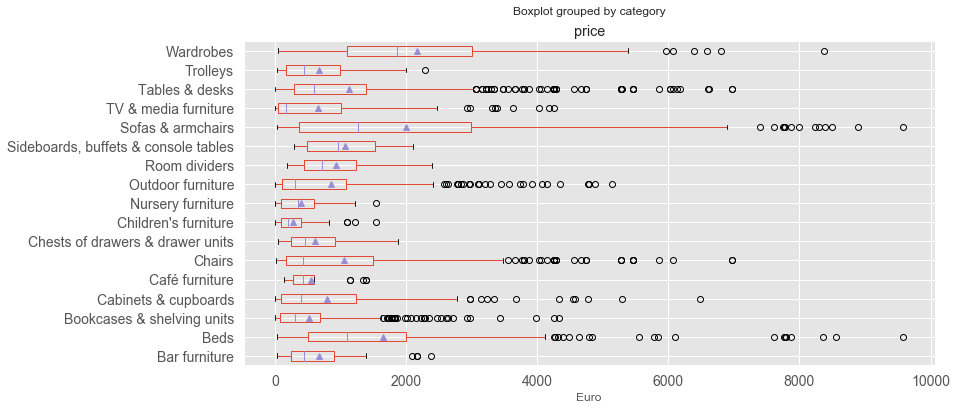

In [19]:
ax2 = IKEA_df.boxplot(column='price',by='category',vert=False, figsize=(12,6), fontsize =14,showmeans =True)
ax2.set_xlabel('Euro')
ax2.figure.savefig('Figures/price_boxplot.pdf',bbox_inches = 'tight')

As shown above in the boxplot of price, the furniture of the category Wardrobes are the most expensive, while the children's furnitures are the cheapest. Sofa & armchairshas has the biggest range in price from about 250€ to 70.000€ while the ourliers can reach up to 90.000€. Cafe furniture has the most stable price. The price area (Interquartile Range of price) of some categories do overlap, but in general it is fair to say that price can be a useful feature in order determine the category.

### old_price

In [20]:
t = IKEA_df[IKEA_df['old_price'].str.contains('No old price')]['item_id'].count() /m
print( str( round(t,4)*100) + '% of feature old_price is no old price' )

82.3% of feature old_price is no old price


Furthermore, it is  impossible to recover this data. It follows, that the feature old_price might not be helpful in order to determine the category. Therefore, it can be ignored for training. 

### sellable_online

In [21]:
t = IKEA_df[IKEA_df['sellable_online'] == True]['item_id'].count()/m
print( str( round(t,4)*100) + '% of feature sellable_online is True' )


99.24% of feature sellable_online is True


This indicates, that this feature cannot help to determine the category and therefore can be deleted for training.

### other_colors

In [22]:
t = IKEA_df[IKEA_df['other_colors'].str.contains('Yes')]['item_id'].count()/m
print( str( round(t,4)*100) + '% of feature other_colors is Yes.' )


40.93% of feature other_colors is Yes.


### designer

In [23]:
nun_designer =  IKEA_df['designer'].nunique()
#print(IKEA_df['designer'].unique())
print('There are ' + str(nun_designer) + ' different designers in total' )

There are 381 different designers in total


In [24]:
designer_df = IKEA_df.groupby('designer').size().reset_index(name='count').sort_values(['count'], ascending=False)
designer_df['count%'] = round(designer_df['count'] *100/m ,2) 

In [25]:
designer_df.head(5)

,designer,count,count%
192,IKEA of Sweden,828,22.41
138,Ehlén Johansson,161,4.36
163,Francis Cayouette,151,4.09
344,Ola Wihlborg,134,3.63
279,K Hagberg/M Hagberg,122,3.30


In [26]:
t = designer_df[designer_df['count']< 2].shape[0]
print(str(t)+ ' of ' + str(nun_designer)+'designers design just 1 items in dataset')

139 of 381designers design just 1 items in dataset


In [27]:
t = designer_df[designer_df['count']< 5].shape[0]
print(str(t)+ ' of ' + str(nun_designer)+' designers design less than 5 items in dataset')

278 of 381 designers design less than 5 items in dataset


In [28]:
t  = designer_df[designer_df['count']< 10].shape[0]
print(str(t)+ ' of ' + str(nun_designer)+' designers design less than 10 items in dataset')

320 of 381 designers design less than 10 items in dataset


In [29]:
IKEA_df['designer_len'] = IKEA_df['designer'].str.len() 
IKEA_df['designer_len'].describe()

count    3694.000000
mean       33.755820
std        86.016629
min         3.000000
25%        14.000000
50%        15.000000
75%        28.000000
max      1261.000000
Name: designer_len, dtype: float64

In [30]:
t = IKEA_df[IKEA_df['designer_len'] > 40].shape[0] 
print(str( round(t*100/m,2)) +'% samples have actually text of long description in feature designer' )

7.26% samples have actually text of long description in feature designer


We find that some entries in desinger is actually a more detailed description of the furniture itself. We could replace them with "designer unknowm", however,  this might be misleading to the algorithm as it could be understood as if the furniture was designed by the same person when instead the designer is not known. 
Moreover we observe that furniture of the same category might have the same text with a long description for the feature **designer**. Considering those mistakes acount for 7% of the whole dataset, we can also just keep the original ones.

In [31]:
IKEA_df[IKEA_df['designer_len'] > 40].head(2)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,designer_len
51,50468953,VATTVIKEN,Beds,995.0,No old price,True,https://www.ikea.com/sa/en/p/vattviken-armchai...,No,Armchair-bed,504.689.53 Small and easy-to-place chair-bed w...,83.0,86.0,92.0,403
77,90331091,RIDABU,Beds,100.0,SR 125,True,https://www.ikea.com/sa/en/p/ridabu-mirror-doo...,No,"Mirror door, 40x120 cm",903.310.91 The door can be hung with the openi...,NaN,120.0,40.0,199


We now examine the favorite furniture category of the TOP3 designers:
1. IKEA of Schweden (22.41%)
2. Ehlén Johansson (4.36%)
3. Francis Cayouette (4.09%)

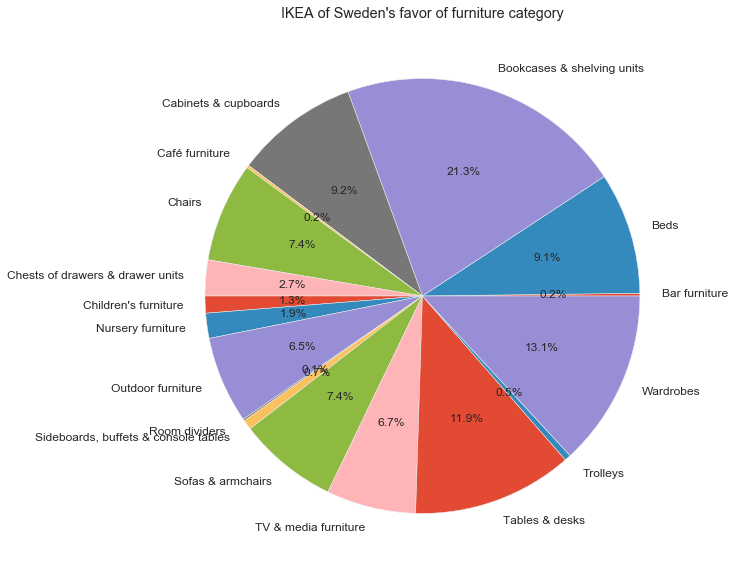

In [32]:
df1 = IKEA_df[IKEA_df['designer'].str.contains('IKEA of Sweden')].groupby('category')['item_id'].count() \
                                    .reset_index(name = 'count')
axd1 = df1.set_index('category').plot.pie(title='IKEA of Sweden\'s favor of furniture category', y='count',figsize=(10,10), \
                                          autopct='%1.1f%%', fontsize=12, legend = None)
axd1.set_ylabel('')
#axd1.legend(bbox_to_anchor=(1.5,0.5), loc="right", fontsize=12)
axd1.figure.savefig('Figures/TOP1_designer.pdf',bbox_inches = 'tight')

IKEA of Sweden covers all 17  furniture catogeries and favor the Bookcases & shelving units.

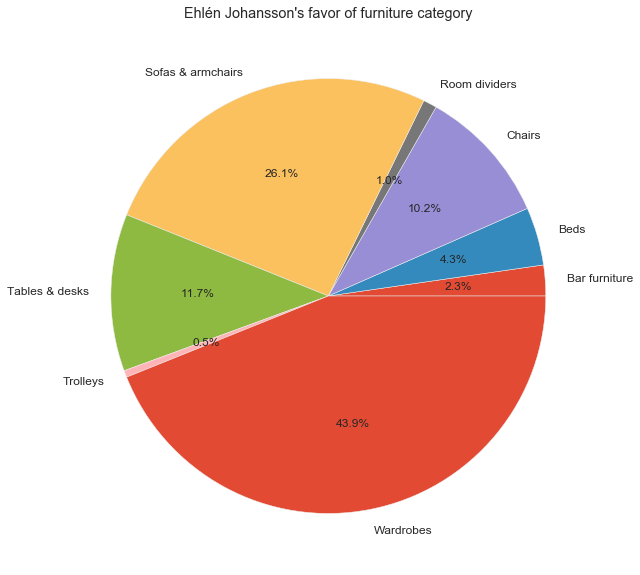

In [33]:
df2 = IKEA_df[IKEA_df['designer'].str.contains('Ehlén Johansson')].groupby('category')['item_id'].count() \
                                    .reset_index(name = 'count')
axd2 = df2.set_index('category').plot.pie(title='Ehlén Johansson\'s favor of furniture category', y='count',figsize=(10,10), \
                                          autopct='%1.1f%%', fontsize=12, legend = None)
axd2.set_ylabel('')
#axd2.legend(bbox_to_anchor=(1.5,0.5), loc="right", fontsize=12)
axd2.figure.savefig('Figures/TOP2_designer.pdf',bbox_inches = 'tight')

In [34]:
t1 = IKEA_df[IKEA_df['category'].str.contains('Wardrobes')]['item_id'].count() 
t2 = IKEA_df[IKEA_df['category'].str.contains('Wardrobes') & IKEA_df['designer'].str.contains('Ehlén Johansson')]['item_id'].count() 
print(round(t2/t1, 4))

0.7331


Designer Ehlén Johansson favors Wardrobes. And indeed, about 73% items of category Wardrobes are designed by Ehlén Johansson (including the cases IKEA of Sweden/Ehlén Johansson and Ehlén Johansson/IKEA of Sweden).

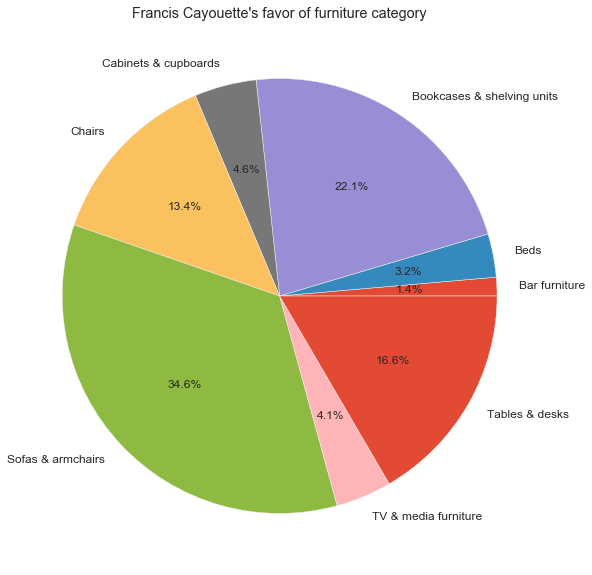

In [35]:
df3 = IKEA_df[IKEA_df['designer'].str.contains('Francis Cayouette')].groupby('category')['item_id'].count() \
                                    .reset_index(name = 'count')
axd3 = df3.set_index('category').plot.pie(title='Francis Cayouette\'s favor of furniture category', y='count',figsize=(10,10),\
                                          autopct='%1.1f%%', fontsize=12, legend = None)
axd3.set_ylabel('')
#axd3.legend(bbox_to_anchor=(1.5,0.5), loc="right", fontsize=12)
axd3.figure.savefig('Figures/TOP3_designer.pdf',bbox_inches = 'tight')

In [36]:
t1 = IKEA_df[IKEA_df['category'].str.contains('Sofas & armchairs')]['item_id'].count() 
t2 = IKEA_df[IKEA_df['category'].str.contains('Sofas & armchairs') & IKEA_df['designer'].str.contains('Francis Cayouette')]['item_id'].count() 
print(round(t2/t1, 4))

0.1752


Designer Francis Cayouette favors Sofas & armchairs. In total, around 17% items of category Sofas & armchairs are designed by Francis Cayouette.

### depth, height, width

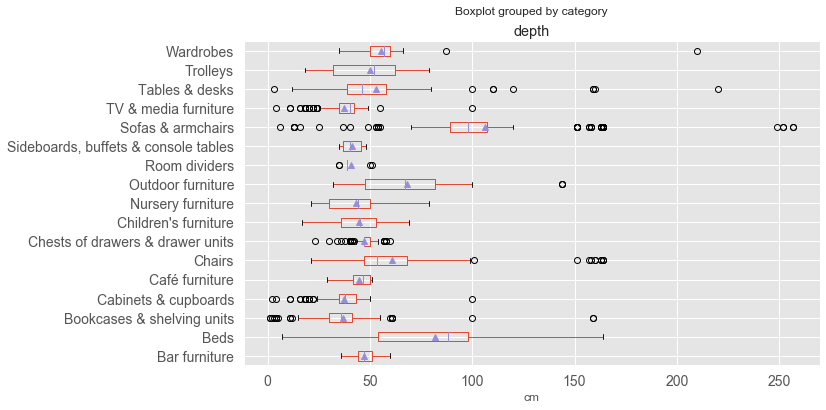

In [37]:
ax3 = IKEA_df.boxplot(column='depth',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax3.set_xlabel('cm')
ax3.figure.savefig('Figures/depth_boxplot.pdf',bbox_inches = 'tight')

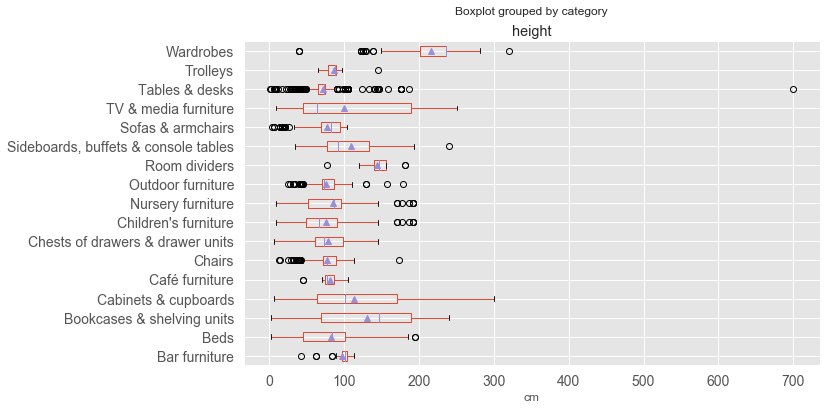

In [38]:
ax4 = IKEA_df.boxplot(column='height',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax4.set_xlabel('cm')
ax4.figure.savefig('Figures/height_boxplot.pdf',bbox_inches = 'tight')


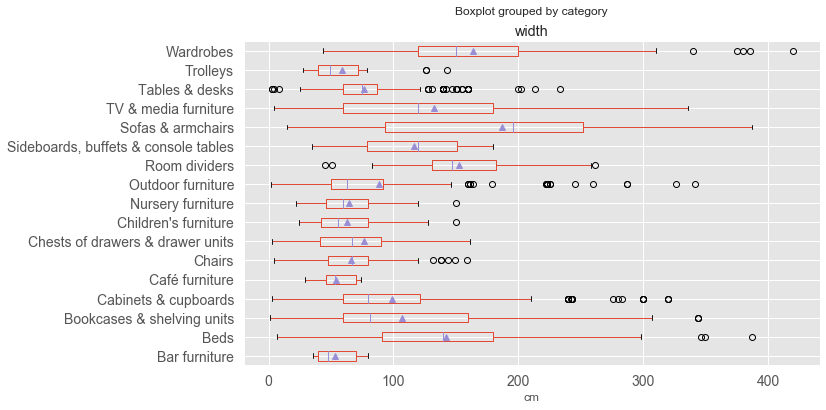

In [39]:
ax5 = IKEA_df.boxplot(column='width',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax5.set_xlabel('cm')
ax5.figure.savefig('Figures/width_boxplot.pdf',bbox_inches = 'tight')


Generally, the feature of size varies a lot for the different categories. This is the case in particular for the feature **depth**. Hence, the feature of size might play an important role in prediction of category. 

### link, short_description
Feature **link** and **short_desctiption** can be understood literally. Both feature **link** and **short_description** are different for the individual items and uncorrelated to the category. Therefore, **link** and **short_description** will be ignored for the training. However, it should not go unnoted that short description contains size data,  which are not scrapped correctly as feature **depth,height,width**. We can make use of this and recover the NaN in **depth,height,width**. Unfortunately, in most cases this is technically too compilicated. Furthermore, both feature **link** and **short_description** contain key words, which indicate  its category directly. It might be kind of cheating to make use of that, while at the same time it would be extremely difficult to do so.

## Correlation
We would like to check the colinerity of numerical (including boolean) features. We can encode the nominal features to integer values by using factorization. Although, this could be misleadings in some way, at this point we just want to have an idea of the correlation between features. In case of training an algorithm that does not understand nominal features, we might use the one-hot encoding to avoid misunderstandings caused by numeric values. However, this leads to quite high computational cost. For example, for 370 different designers, one-hot encoding will create 9 more features, respectively, taking value 0/1 to present the feature designer.

In [40]:
corr_df = IKEA_df.copy()

In [41]:
corr_df['category'] = pd.factorize(corr_df['category'])[0] + 1
corr_df['name'] = pd.factorize(corr_df['name'])[0] + 1
corr_df['sellable_online'] = pd.factorize(corr_df['sellable_online'])[0] + 1
corr_df['other_colors'] = pd.factorize(corr_df['other_colors'])[0] + 1
corr_df['designer'] = pd.factorize(corr_df['designer'])[0] + 1

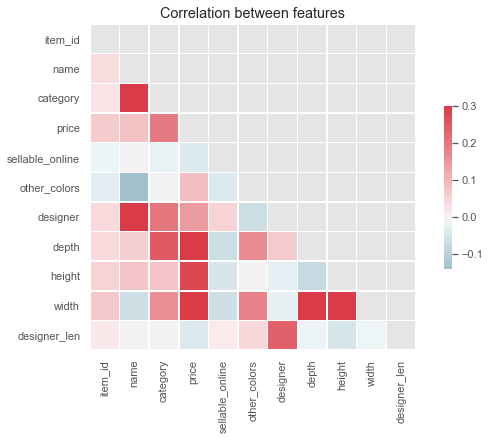

In [42]:
# correlation / scatter matrix here
corr = corr_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation between features')
ax.figure.savefig('Figures/corr.pdf',bbox_inches = 'tight')

As shown in the analysis of the individual features above, **depth** and **price** play the relative more important role in determining the **category**, while **sellable_online** and **other_colors** is less correlated to **category**. 
The price of the items is relative high correlated with depth of items and the name of items is relative high correlated with designer, indicating the colinearity of the features, which might result in bad prediciton in certain algorithms. Anyways, the correlation between features (including the target category) are not at on a high level as all of them are below 0.3.

## Data Cleaning

In [43]:
#convert object to boolean
IKEA_df['other_colors'] = IKEA_df['other_colors'].map({'Yes': True, 'No': False})

In [44]:
IKEA_df[IKEA_df['designer'].str.contains('IKEA of Sweden/Ehlén Johansson')].shape

(79, 14)

In [45]:
IKEA_df[IKEA_df['designer'].str.contains('Ehlén Johansson/IKEA of Sweden')].shape

(86, 14)

In [46]:
# merging 'IKEA of Sweden/Ehlén Johansson' and 'Ehlén Johansson/IKEA of Sweden'
# we noticed when the designers that this is one and the same designer
IKEA_df['designer']= np.where(IKEA_df['designer'].str.contains('IKEA of Sweden/Ehlén Johansson'),  'Ehlén Johansson/IKEA of Sweden', IKEA_df.designer)


The following will let us make the conclusion, that any 'NaN' is in the row containing the data concerning regarding the item-size:

In [47]:
# determine where data is missing (cell is NaN)
shape_NaN = IKEA_df[IKEA_df.isnull().any(axis=1)].shape 
IKEA_df[IKEA_df.isnull().any(axis=1)].head(4)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,designer_len
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,False,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0,20
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,False,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0,17
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,False,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,17
7,60155602,DALFRED,Bar furniture,195.0,No old price,True,https://www.ikea.com/sa/en/p/dalfred-bar-stool...,False,"Bar stool, 63-74 cm",Sarah Fager,50.0,NaN,50.0,11


It seems like the data is only missing regarding item-size (depth, height, width). Let's check if that is the case:

In [48]:
size = ['depth','height','width'] 
shape_size = IKEA_df[IKEA_df[size].isnull().any(axis=1)].shape 
if shape_size == shape_NaN:
    print('The assumption from above seems to be correct. The only data missing is regarding the item-size')

The assumption from above seems to be correct. The only data missing is regarding the item-size


In [49]:
IKEA_df[IKEA_df[IKEA_df.columns[~IKEA_df.columns.isin(size)]].isnull().any(axis=1)].shape

(0, 14)

In [50]:
IKEA_df[IKEA_df[size].isnull().all(axis=1)].head(4)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,designer_len
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,False,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,17
9,69304221,EKEDALEN / EKEDALEN,Bar furniture,2176.0,"SR 2,375",True,https://www.ikea.com/sa/en/p/ekedalen-ekedalen...,False,Bar table and 4 bar stools,Ehlén Johansson,NaN,NaN,NaN,15
28,29297227,STENSELE / NORRARYD,Bar furniture,1340.0,No old price,True,https://www.ikea.com/sa/en/p/stensele-norraryd...,False,Bar table and 2 bar stools,Nike Karlsson/Maja Ganszyniec,NaN,NaN,NaN,29
32,19297275,NORRÅKER / NORRÅKER,Bar furniture,1266.0,"SR 1,385",True,https://www.ikea.com/sa/en/p/norraker-norraker...,False,"Bar table and 2 bar stools, 7...",J Karlsson/N Karlsson,NaN,NaN,NaN,21


### NaN in size data

According to the observations made by comparing the given dataset to the product size shown on the website, we came to the conclusion, that there are several main reasons as to why data of the category size is missing \.
First of, it seems that some data is not successfully scraped from the website and not recorded in the short description either making it is impossible to recover the missing data. \
Second, some items represent a set of different furniture. Therefore there is no product size in that sense. \
Third, some items have variable size, for example, an items width width can vary from 190 cm up to 220 cm. Although some data is recorded in the short description, it is very difficult to extract the exact size for all items. The biggest problem is that it cannot be identified what numbers respond to depth, height and width, especially since that data in the short description often is incomplete.\
Last of, there are some small items where the measurements ar taken in milimeters instead of centimeter. Furthermore, for some items a item-diameter was recorded in the short descritpion instead of the item-height.


In [51]:
#split description and size data in feature short description
IKEA_df['size']= IKEA_df['short_description'].str.rsplit(',', n=1).str[1]
IKEA_df['short_description']= IKEA_df['short_description'].str.rsplit(',', n=1).str[0]

In [52]:
#split numbers and unit
IKEA_df['unit'] = IKEA_df['size'].str.replace('\d+|-|x', ' ')
IKEA_df['size_nounit'] = IKEA_df['size'].str.replace('cm|mm', '')

The following shows that indeed, **height** is not given for the small items. Thus, in this case it is convenient to extract the diameter from the short description representing the diameter and replacing the NaN in height with the recorded data from **short description**. Additionally, we find, that ccording to the link the size-data for small items, of which the diameter is measured with mm, is actually mm as well. Therefore this is corrected in the following.  

In [53]:
IKEA_df[IKEA_df['unit'].str.contains('mm') & IKEA_df[size].isnull().any(axis=1)].shape

(132, 17)

In [54]:
IKEA_df[IKEA_df['unit'].str.contains('mm') & IKEA_df['height'].isnull()].shape

(132, 17)

In [55]:
IKEA_df['height'] = np.where(IKEA_df['unit'].str.contains('mm') , IKEA_df.size_nounit, IKEA_df.height)
IKEA_df['height'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.height.astype(float)/10, IKEA_df.height)
IKEA_df['height'] = IKEA_df['height'].astype(float)

In [56]:
IKEA_df['depth'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.depth.astype(float)/10, IKEA_df.depth)
IKEA_df['width'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.width.astype(float)/10, IKEA_df.width)

For simplicity, the NaN-cells in size-data is filled with either the mean or the median depending on the category and wether there are many outliers in size data (refer to the boxplot earlier). In case there are many outliers resulting in the mean beeing significantly higher than the median, the NaN-cells are filled with the median.

In [57]:
#calculate median/mean of items of each furniture category 
dm =IKEA_df.groupby('category')['depth'].median().reset_index(name = 'depth_median')
dd = IKEA_df.groupby('category')['depth'].mean().reset_index(name = 'depth_mean')
hm = IKEA_df.groupby('category')['height'].mean().reset_index(name = 'height_mean')
hd = IKEA_df.groupby('category')['height'].median().reset_index(name = 'height_median')
wm= IKEA_df.groupby('category')['width'].median().reset_index(name = 'width_median')
wd =IKEA_df.groupby('category')['width'].mean().reset_index(name = 'width_mean')

In [58]:
IKEA_df = IKEA_df.join(dm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(dd.set_index('category'), on='category')
IKEA_df = IKEA_df.join(hm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(hd.set_index('category'), on='category')
IKEA_df = IKEA_df.join(wm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(wd.set_index('category'), on='category')

In [59]:
IKEA_df['depth'] = np.where( (IKEA_df['depth'].isnull()) & (IKEA_df['category'].str.contains('Tables & desks')),  \
                              IKEA_df.depth_median, IKEA_df.depth )
IKEA_df['depth'] = np.where( (IKEA_df['depth'].isnull()) & (IKEA_df['category'].str.contains('Sofas & armchairs')),  \
                              IKEA_df.depth_median, IKEA_df.depth )        
IKEA_df['depth'] = np.where( (IKEA_df['depth'].isnull()) & (IKEA_df['category'].str.contains('Chairs')),  \
                              IKEA_df.depth_median, IKEA_df.depth )

In [60]:
IKEA_df['height'] = np.where( (IKEA_df['height'].isnull()) & (IKEA_df['category'].str.contains('TV & median furniture')),  \
                              IKEA_df.height_median, IKEA_df.height )
IKEA_df['height'] = np.where( (IKEA_df['height'].isnull()) & (IKEA_df['category'].str.contains('Sideboards, buffets,console tables')),  \
                              IKEA_df.height_median, IKEA_df.height )

In [61]:
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Wardrobes')),  \
                            IKEA_df.width_median, IKEA_df.width)
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Outdoor furniture')),  \
                            IKEA_df.width_median, IKEA_df.width)
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Carbinets & cupboards')),  \
                            IKEA_df.width_median, IKEA_df.width)
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Bookcases & shelving units')),  \
                            IKEA_df.width_median, IKEA_df.width)

In [62]:
IKEA_df['depth'] = np.where(IKEA_df['depth'].isnull(), IKEA_df.depth_mean, IKEA_df.depth)
IKEA_df['height'] = np.where(IKEA_df['height'].isnull(), IKEA_df.height_mean, IKEA_df.height)
IKEA_df['width'] = np.where(IKEA_df['width'].isnull(), IKEA_df.width_mean, IKEA_df.width)

In [63]:
# save data_frame
with open('Data/IKEA_df.p', 'wb') as df:   
    pickle.dump(IKEA_df, df)

## Prediction with Tree-based algorithm 
Tree-based algorithms do not work on calculating distance. Therefore it is sufficient to factorize the categorical features.

In [64]:
learn = ['item_id','name','category','price','sellable_online','other_colors','designer','depth','height','width' ]
learn_df = IKEA_df [learn]

In [65]:
#chek if there is still  NaN in dataset
learn_df[learn_df.isna().any(axis =1)]['item_id'].count()

0

In [66]:
#this cell gives warning about setting copy. this warining can be ignored in this project
#encode nominal feature into numeric ones
learn_df['category_num'] = pd.factorize(learn_df['category'])[0] + 1
learn_df['name'] = pd.factorize(learn_df['name'])[0] + 1
#learn_df['sellable_online'] = pd.factorize(learn_df['sellable_online'])[0] + 1
#learn_df['other_colors'] = pd.factorize(learn_df['other_colors'])[0] + 1
learn_df['designer'] = pd.factorize(learn_df['designer'])[0] + 1

/Users/alissaganter/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/alissaganter/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/alissaganter/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is tr

In [67]:
label = IKEA_df['category'].unique()
label = label.tolist()
print('labels:', label)

labels: ['Bar furniture', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards', 'Café furniture', 'Chairs', 'Chests of drawers & drawer units', "Children's furniture", 'Nursery furniture', 'Outdoor furniture', 'Room dividers', 'Sideboards, buffets & console tables', 'Sofas & armchairs', 'Tables & desks', 'Trolleys', 'TV & media furniture', 'Wardrobes']


In [68]:
t = learn_df.drop(columns = ['category','category_num']).shape[1]
print('There are '+str(t)+' features.')

There are 9 features.


After modifieying and cleaning the data frame, it is suitable for tre-based algorithms.

### Random Forest

**Note**: the exact value of overall accuracy, accuracy in confusion matrix and even ranking of feature importance might slightly differ from the ones written in comments because of randomness in algorithm .

#### First glance : Standard random forest
We first take look at an example calssifier, it is almost a standard random forest classifier apart from that we set min_samples_leaf= 5.

In [69]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(learn_df.drop(columns = ['category','category_num']), \
                                                    learn_df['category_num'], random_state=1)

In [71]:
rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)
a = accuracy_score(y_test, y_pred)
# Note : this acuracy is not weighted by sample size!!! 
print('Overall acuracy of all category: ' +str(a))

Overall acuracy of all category: 0.8041125541125541


**Note** : this overall acuracy is not weighted by sample size , so even for a category with a small size the performance is totally trash, we still have an acceptable overall acuracy.

In [72]:
#check feature importance
feature_impo = pd.Series(data=rf_est.feature_importances_, index=list(X_train.columns))
feature_impo = feature_impo.sort_values(axis=0, ascending=False)
feature_impo

depth              0.302832
height             0.266735
name               0.212154
width              0.077149
price              0.056551
designer           0.051101
item_id            0.016914
other_colors       0.016554
sellable_online    0.000010
dtype: float64

Text(0.5, 1.0, 'Feature importance')

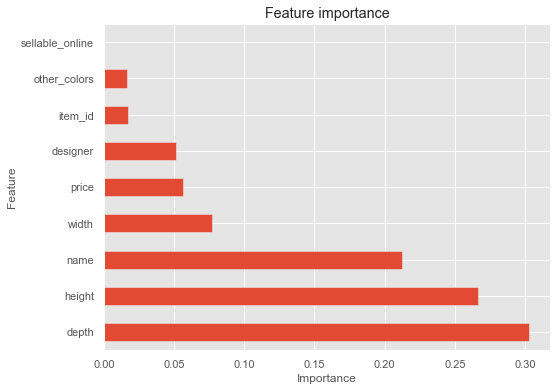

In [73]:
figip,axip = plt.subplots(1,1, figsize=(8,6))
feature_impo.plot(kind='barh', ax=axip)
axip.set_xlabel('Importance')
axip.set_ylabel('Feature')
axip.set_title('Feature importance')

Now lets check the confusion matrix to examine the acuracy for each category

In [74]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

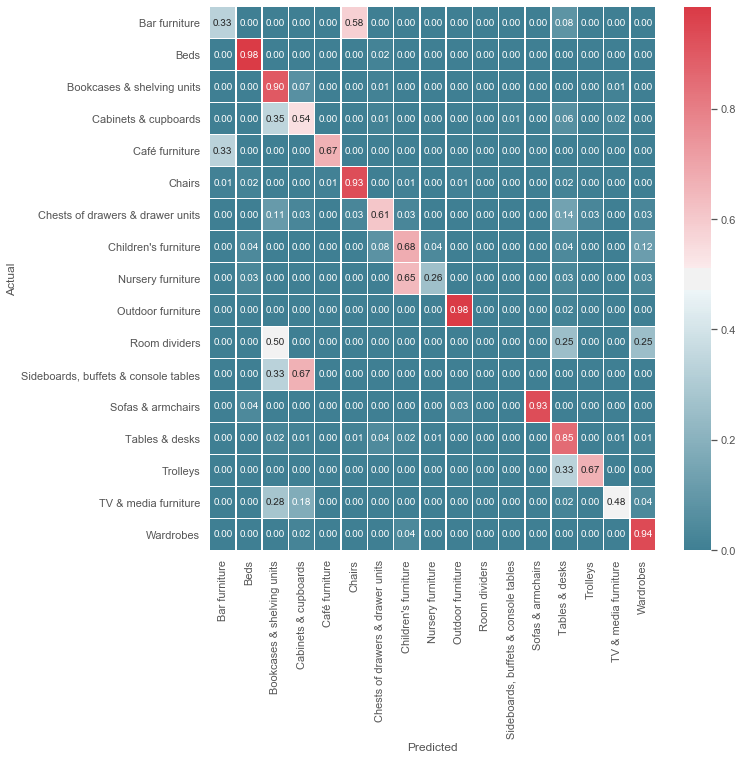

In [75]:
#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/RF_CM_1.pdf', bbox_inches = 'tight')

An analysis of this confusion matrix will be given later; toghether with next plot.

#### Further feature selection by only keeping the important features
From feature importance report we get that size data  play the  great role in prediction, as we asuumed before in feature analysis. In addition name of the items is also important. Lets see what happens if we just keep those 5 top features with importance  larger than around 5%. We remove the feature **sellable online**, **item_id** and **other_colors**.

In [76]:
# we need item_id and category in dataframe for ohther use, not for training
learn1 = ['item_id','height','depth','width','name','designer','category','category_num']
learn_df1 = learn_df[learn1]

In [77]:

X_train, X_test, y_train, y_test = train_test_split(learn_df1.drop(columns = ['item_id','category','category_num']), \
                                                    learn_df1['category_num'], random_state=1)
rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)
a = accuracy_score(y_test, y_pred)
print('Overall acuracy of all category: ' +str(a))

Overall acuracy of all category: 0.827922077922078


The overall acuracy increased from about 80% to 82%

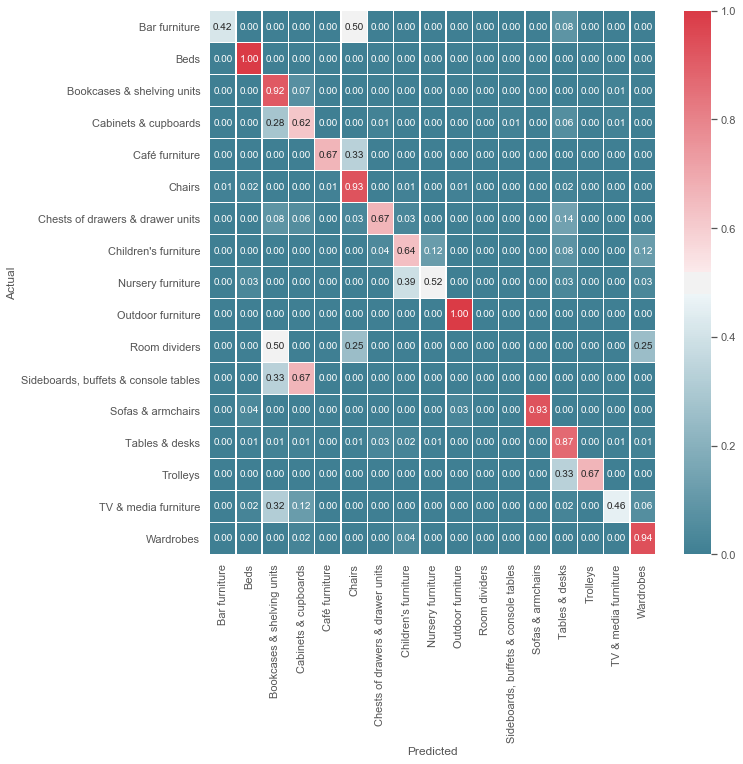

In [78]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/RF_CM_2.pdf', bbox_inches = 'tight')

Compare the both confusion matrix we get that through feature selection,  we increase the overall accuracy at about1%  in the way that the accuracy for category Nursury furniture have been significantly increased by 10% respectly. And it is clear that the category with the worst performance: Room diveider with 0%, Sideboards & console tables with 0%, then Bar furniture 42%. Those are exactly the category with smallest sample size in whole dataset. As we mentioned above we can replicate  those samples to make it to a  ralative balanced multi-class classification task. The category TV & media furniture perform also not good, 30% TV& medianfurnitures have been predicted as Book cases & shelving unit. Considering the feature importance and boxplot of height and depth, we find that those two category have really simillar distribution shown in boxplot of those top 2 features.No wonder then.To our supprise, category Trolleys ,of which samples size is just 28, has the outstanding performance. We did not find the obvious clue from  its size  and price. We take look at the data set and find  the option for its name and designer is restricted and this might be the reason.  

#### Replicate the samples for small sample size category  

Now we replicate the samples of category **Room diveifer** and **Sideboards, buffets & console tables** in dataset to make this multi class classification task be relative balanced and see of it will significantly iprove the performance.

In [79]:
#recall the sample size of each category
size_df = learn_df1.groupby('category').size().reset_index(name='size')

In [80]:
size_df 

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


In [81]:
# careful here the order of the labels somehow changed compared with list'label' above. The order of TV & median furniture
# tables& dsks and trollyes somehow excahnged seeing below . We can't direct use list label to present the correct order of 
# column names in this section.
label1 =size_df['category'].tolist()

In [82]:
#label

In [83]:
label1

['Bar furniture',
 'Beds',
 'Bookcases & shelving units',
 'Cabinets & cupboards',
 'Café furniture',
 'Chairs',
 'Chests of drawers & drawer units',
 "Children's furniture",
 'Nursery furniture',
 'Outdoor furniture',
 'Room dividers',
 'Sideboards, buffets & console tables',
 'Sofas & armchairs',
 'TV & media furniture',
 'Tables & desks',
 'Trolleys',
 'Wardrobes']

In [84]:
label_size = size_df['size'].tolist()

In [85]:
label_size

[47, 208, 548, 292, 26, 481, 125, 124, 97, 216, 13, 23, 428, 190, 612, 28, 236]

In [86]:
learn_df2 = learn_df1.copy()

In [87]:
# using label1 instead of label !!!!!
#print(learn_df2.shape[0])
for k in range(17):
    temp_df = learn_df1[learn_df1['category'].str.contains(label1[k])] 
    #print('original size' + str(temp_df.shape[0]))
    #print('label_size' +str(label_size[k]))
    tt = round(max(label_size)/label_size[k]) -1
    #print('to replicate' + str(tt))
    if tt > 0:
        temp_df1 = pd.concat([temp_df]*tt, ignore_index=True)
        #print('df_repl size' +str(temp_df1.shape[0]))
        learn_df2 = pd.concat([learn_df2, temp_df1] , ignore_index=True)
        #print(learn_df2.shape[0])

In [88]:
# old dataset imbalanced
size_df

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


In [89]:
#new relative balanced data set with duplicated samples
size_df2 = learn_df2.groupby('category').size().reset_index(name='size')
size_df2

,category,size
0,Bar furniture,611
1,Beds,624
2,Bookcases & shelving units,548
3,Cabinets & cupboards,584
4,Café furniture,624
5,Chairs,481
6,Chests of drawers & drawer units,625
7,Children's furniture,620
8,Nursery furniture,582
9,Outdoor furniture,648


Now the data set has been modified to be a relative balanced ones , although there are now too many duplicated samples for category, which had too few samples before.

#### Final random forest model

In [90]:
X_train, X_test, y_train, y_test = train_test_split(learn_df2.drop(columns = ['item_id','category','category_num']), \
                                                    learn_df2['category_num'], random_state=1)
rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)
a = accuracy_score(y_test, y_pred)
print('Overall acuracy of all category: ' +str(a))

Overall acuracy of all category: 0.8896797153024911


Through replicate samples , we increase the overall accuracy from about 82% to 89%.

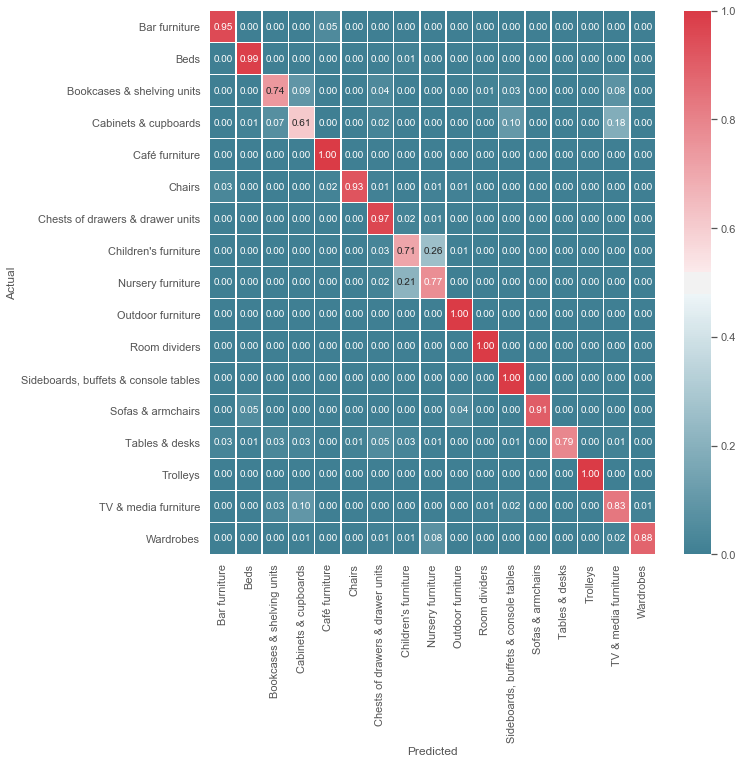

In [91]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('Figures/RF_CM_3.pdf', bbox_inches = 'tight')

Now we have an almost perfect diagonal matrix we desired. Through repeating samples to make size of each category  balanced,  the acuracy of prediction for Bar funiture has been increased from 42% to 95% ,  for Room dividers from 0% to 100%,  for Sideboards, buffets & console rable from 0% to 100% etc. It is still hard for the algorithm to distinguish nursery furniture from children furniture.The reason is clear that consering two the immportant features: height and depth, the distribution are almost the same in the box plot.  

In [92]:
feature_impo = pd.Series(data=rf_est.feature_importances_, index=list(X_train.columns))
feature_impo = feature_impo.sort_values(axis=0, ascending=False)
feature_impo

name        0.299247
depth       0.279683
height      0.240460
width       0.105361
designer    0.075249
dtype: float64

And now with replicated samles in data set , the feature name(former) becomes the most important feature, followed by height (former top1) and depth(former top2).

 Now we try out different parameter settings to see if we can get better predictions. After trail and error we keep the following parameter sets to show the impact of those parameters. Best minimum samples in leaf  is  1 (we set 5 before), if increase the size the overall predictions accuracy goes down. Normally the acurracy increase with the size of forest until  reaching certain threshold and the accuracy become stable. In total those parameters just influence the overall acuracy less than 0.01, and the best overall accuracy witih random forest is about 90.27% for minimum_samples_leaf =1, n_tree = 400. Here we won't check the single confusion matrix, since the dataset is now balanced w.r.t sample size of each category. 

In [93]:
def RandomForest(n_tree, min_leaf, learn_df):
    
    X_train, X_test, y_train, y_test = train_test_split(learn_df.drop(columns = ['category_num','category','item_id']), \
                                                        learn_df['category_num'], random_state=1)
    print('==================='+'Process for Param_'+str(i)+'_'+ str(l)+'===================')
    start_time = time.time()
    rf =  RandomForestClassifier(n_estimators = n_tree,criterion = 'gini', min_samples_leaf = min_leaf,random_state =1)
    rf.fit(X_train,y_train)
    y_pred =  rf.predict(X_test)
    end_time = time.time()
    print('time consumption: '+ str(end_time - start_time))
    # overall acuracy
    a = accuracy_score(y_test, y_pred)
    print('Overall acuracy: ' +str(a))
# uncomment all below to check the confusion matrix for each loop
#     # confusion matrix   
#     m =  confusion_matrix(y_test, y_pred)
#     #calculate total number of samples of each category in X_test
#     m_sum = m.sum(axis = 1)
#     m1 = np.zeros((17,17))
#     for k in range(17):
#          m1[k,:] = m[k,:]/m_sum[k]
#     m_df = pd.DataFrame(m1,index = label, columns=label)
#     #plot confusion matrix
#     fig, ax = plt.subplots(figsize=(10,10))
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
#     sns.heatmap(m_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
#     ax.set_xlabel('Predicted')
#     ax.set_ylabel('Actual')
#     ax.figure.savefig('Figures/RF_CM_Param_'+str(i)+ '_' + str(l) +'_'+str(round(a,3))+'_.jpg',bbox_inches = 'tight')

In [94]:
# number of the  decision tree in forest
n_tree = [20,50,100,200,400,600]
# those two criterion almost make no difference to overall acuracy,  too complicated to examine their impact on each category
# so just use the default gini index
#crit = ['gini','entropy']
# minimum number of samples in the leaf (end node)
min_leaf = [1,3,5,7]

In [95]:
for i in range(len(n_tree)):
        for l in range(len(min_leaf)):
            RandomForest(n_tree[i], min_leaf[l],learn_df2)

===================Process for Param_0_0===================
time consumption: 0.20699286460876465
Overall acuracy: 0.8983788058521155
===================Process for Param_0_1===================
time consumption: 0.18719887733459473
Overall acuracy: 0.8952155001977066
===================Process for Param_0_2===================
time consumption: 0.17375898361206055
Overall acuracy: 0.8908659549228944
===================Process for Param_0_3===================
time consumption: 0.1659071445465088
Overall acuracy: 0.8805852115460656
===================Process for Param_1_0===================
time consumption: 0.4159879684448242
Overall acuracy: 0.9023329379201266
===================Process for Param_1_1===================
time consumption: 0.4158480167388916
Overall acuracy: 0.8940292605773033
===================Process for Param_1_2===================
time consumption: 0.4342670440673828
Overall acuracy: 0.8916567813364966
===================Process for Param_1_3===================
time c

### Boosting